## HMM Baum Welch Implementation



### Main functions for the algorithm

In [1]:
#V = sequences
#a = transition
#b = emission
from tqdm.notebook import tqdm
import numpy as np
import itertools

def forward_run(seq, emission, transition, initial_distribution):
    alpha = np.zeros((len(seq), transition.shape[0]))
    # Initialising first position
    alpha[0, :] = initial_distribution * emission[:, seq[0]]

    # main loop
    for i in range(1, len(seq)):

        for j in range(0, transition.shape[0]): #Through number of states
            
            alpha[i,j] = np.dot(alpha[i-1], transition[:,j])*emission[j, seq[i]]
    
    return(alpha)

def backward_run(seq, emission, transition):
    beta = np.zeros((len(seq), transition.shape[0]))
    #initialising last position
    beta[len(seq)-1] = np.ones((transition.shape[0]))
    
    for i in range(len(seq) - 2, -1, -1): #Run backwards through the sequence
        for j in range(transition.shape[0]):
            beta[i,j] = np.dot((beta[i+1]*emission[:, seq[i+1]]), transition[j,:])
    
    return(beta)

def baum_welch(train_seq_list, test_seq_list, transition, emission, initial_distribution, n_iter=50):
    
    #Ensure shape of seqlist
    if len(train_seq_list.shape) != 2:
        seq_list = np.array([train_seq_list])

    M = transition.shape[0] #number of hidden states
    T = train_seq_list.shape[1]   #lenght of each sequence
    R = train_seq_list.shape[0]   #number of sequences
    train_log = np.zeros(n_iter)
    
    for n in tqdm(range(n_iter), leave=False):
        xi_list = []
        gamma_list = []

        for seq in train_seq_list:

            alpha = forward_run(seq, emission, transition, initial_distribution)
            beta  = backward_run(seq, emission, transition) 

            #On the fly normalisation:
            norm_fact = np.sum(alpha, axis = 1)

            for i in range(alpha.shape[1]):
                alpha[:,i] = alpha[:,i]/norm_fact
                beta[:,i] = beta[:,i]/norm_fact
        
            train_log[n] += np.sum(np.log(alpha[:,-1]))/n_iter
        
            #xi[i,j] probability of transition from hidden state i to hidden state j at time t given observations:
            xi = np.zeros((M, M, T-1))

            for t in range(T-1):
                # The denominator gives the probability of observing the seq given the parameters.
                # Which equals getting the observation by the sum of paths through the model.

                d1 = np.dot((alpha[t,:].T), transition*emission[:, seq[t + 1]].T)

                denominator = np.dot(d1, beta[t+1, :])

                for i in range(M):
                    numerator = alpha[t,i] * transition[i,:] * emission[:, seq[t+1]].T * beta[t+1, :].T
                    xi[i, :, t] = numerator / denominator
            
            xi_list.append(xi)

            
            # probability at given state i and time t given the observed sequence.
            gamma = np.sum(xi, axis=1)
            gamma_list.append(gamma)
        
        
        
        ### Maximization step
        #Initial dist:
        initial_distribution = gamma_list[0][:,0]
        for i in range(1,R):
            initial_distribution += gamma_list[i][:,0]
        initial_distribution = initial_distribution / R
        #initial_distribution = sum([gamma[:,0] for gamma in gamma_list]) / R
            
            
        #update transition
        trans_nom = np.sum(xi_list[0], axis = 2)
        trans_denom = np.sum(gamma_list[0], axis=1).reshape((-1,1))
        
        for i in range(1, R):
            trans_nom += np.sum(xi_list[i], axis = 2)
            trans_denom += np.sum(gamma_list[i], axis=1).reshape((-1,1))
        
        transition =  trans_nom/trans_denom
        
        #Ensure T elements in Gamma, gamma has lenght T-1 and T emissions are needed.
        gamma_list = [np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1,1)))) for gamma, xi in zip(gamma_list, xi_list)]

        K = emission.shape[1]
        
        emis_denom = np.sum(gamma_list[0], axis=1) 
        for i in range(1,R):
            emis_denom += np.sum(gamma_list[i], axis=1) 
                  
        
        for l in range(K):
            emission[:, l] = np.sum(gamma_list[0][:, train_seq_list[0] == l], axis=1)
        
        emission_temp = emission.copy()
        for i in range(1,R):
            for l in range(K):
                emission_temp[:, l] = np.sum(gamma_list[i][:, train_seq_list[i] == l], axis=1)
            emission += emission_temp

        emission = np.divide(emission, emis_denom.reshape((-1,1)))
    
    # Get the probability of the test sequences given the trained parameters
    model_prob = 0
    for seq in test_seq_list:
        alpha = forward_run(seq, emission, transition, initial_distribution)
        model_prob += np.sum(np.log(alpha[:,-1], out=np.zeros_like(alpha[:,-1]), where=(alpha[:,-1])!=0))
    model_prob = model_prob/len(test_seq_list)
    return(np.round(emission,3), np.round(transition,3), initial_distribution, np.round(model_prob,2), train_log)


    

### Support functions

In [2]:
def encode_seq(symbols, sequence):

    
        enc = [0] * len(sequence)

        for i in range(len(sequence)):
            enc[i] = symbols.find(sequence[i])

        return(np.array(enc))
    
def genSeq(n, init_dist, trans, emission):
    states = []
    vis = []
    
    state = np.random.choice([x for x in range(len(init_dist))], p=init_dist)
    
    for i in range(n):
        state = np.random.choice([x for x in range(len(trans[state]))], p=trans[state])
        v = np.random.choice([x+1 for x in range(len(emission[state]))], p=emission[state])
        states.append(str(state))
        vis.append(str(v))
    states = "".join(states)
    vis = "".join(vis)
    
    return(states, vis)


def calc_mse(x,y):
    err = np.mean(np.power(x-y,2))
    return(err)

def evaluate_performance(est_emission, est_transition, est_init, emission, transition, init):
    
    est_par = np.concatenate([est_emission, est_transition, est_init.reshape(-1,1)], axis=1)
    true_par = np.concatenate([emission, transition, init.reshape(-1,1)], axis=1)
    
    mse_list = []
    for state_order in itertools.permutations(est_par, len(est_par)):
        mse_list.append(calc_mse(state_order, true_par))
        
    return(mse_list)

def combine_ensemble(emission_list, transition_list, init_list, loglikelihood_list):
    
    # Determine reference run by best likelihood
    R = len(emission_list) #number of runs
    
    ref_index = np.argmax(loglikelihood_list)
    print("reference model: ", ref_index+1)
    ref_comb_par = np.concatenate([emission_list[ref_index], 
                                   transition_list[ref_index], 
                                   init_list[ref_index].reshape(-1,1)], 
                                  axis=1)
    
    #rotated parameters for each run with least mse to ref:
    rot_par = []
    
    for r in range(R):
        comb_par = np.concatenate([emission_list[r], transition_list[r], init_list[r].reshape(-1,1)], axis=1)
        mse = []
        rotation = []
        for state_rotation in itertools.permutations(comb_par, len(comb_par)):
            rotation.append(state_rotation)
            mse.append(calc_mse(state_rotation, ref_comb_par))
        
        # keep the rotation with the smallest mse
        rot_par.append([rotation[np.argmin(mse)]])
    
    #combine all the parameters from the runs rotated to match reference.
    
    ens_comb_par = np.divide(sum(np.array(rot_par))[0],R)

    #Slice into each matrix:
    len_em = emission_list[0].shape[1]
    len_tr = transition_list[0].shape[1]
    
    ens_emission, ens_transition, ens_init = np.split(ens_comb_par,[len_em,len_em+len_tr],axis=1)
    
    
    return(ens_emission, ens_transition, ens_init.flatten())
    



### Main program

Note that the main program is setup to allow MSE comparison with known true parameters for describing the model.

However, simply removing lines (82,83 99) would allow the user to run on sequences with unknown underlying model.

In [3]:
## Run parameters:
np.random.seed(324)

runs = 7 # number of models trained
training_iters = 250 #Number of training iterations pr. model

n_train_seq = 100 # Number of generated simulated sequences
n_test_seq = 30
len_sim_seq = 50 # Lenght of simulated sequences


### Known parameters to generate test sequences:
sim_trans = np.array([
    [0.95,0.05],
    [0.1, 0.9]
])

sim_emission = np.array([
    [1.0/6, 1.0/6, 1.0/6, 1.0/6, 1.0/6, 1.0/6],
    [1.0/10, 1.0/10, 1.0/10, 1.0/10, 1.0/10, 5.0/10]
])

sim_init = np.array([0.5,0.5])

## Generate simulated sequences from a known model
train_seq_list = []
for i in range(n_train_seq):
    states, seq = genSeq(len_sim_seq, sim_init, sim_trans, sim_emission)
    seq = np.array([x for x in seq])
    symbols = "123456"

    seq = encode_seq(symbols, seq)
    train_seq_list.append(seq)

test_seq_list = []
for i in range(n_test_seq):
    states, seq = genSeq(len_sim_seq, sim_init, sim_trans, sim_emission)
    seq = np.array([x for x in seq])
    symbols = "123456"

    seq = encode_seq(symbols, seq)
    test_seq_list.append(seq)
#

est_em_list = []
est_trans_list = []
est_init_list = []
mse_run = []
model_probabilities = []

train_logs = []

for run in tqdm(range(runs)):
    
    #### Initial values
    # Transition Probabilities
    n_states = 2

    transition = np.ones((n_states, n_states))
    transition = transition / np.sum(transition, axis=1)


    # Emission Probabilities
    emission = np.random.uniform(0,1, size=(n_states, len(symbols)))
    emission = emission / np.sum(emission, axis=1).reshape((-1, 1))

    # Equal Probabilities for the initial distribution
    initial_distribution = np.divide(np.ones(n_states), n_states)

    # Run baum_welch 
    est_em, est_trans, est_init, prob, train_log = baum_welch(np.array(train_seq_list),np.array(test_seq_list),
                                                   transition, 
                                                   emission, 
                                                   initial_distribution, 
                                                   n_iter=training_iters)
    train_logs.append(train_log)
    est_em_list.append(est_em) 
    est_trans_list.append(est_trans)
    est_init_list.append(est_init)
    model_probabilities.append(prob)
    
    mse = evaluate_performance(est_em, est_trans, est_init, sim_emission, sim_trans, sim_init)
    mse_run.append(mse)

    
## Computing ensemble of the runs
ensemble_emission, ensemble_transition , ensemble_init = combine_ensemble(emission_list = est_em_list, 
                                                             transition_list = est_trans_list, 
                                                             init_list = est_init_list,
                                                             loglikelihood_list = model_probabilities)

# Get the probability of the sequence given the trained parameters
ensemble_prob = 0
for seq in test_seq_list:
    alpha = forward_run(seq, ensemble_emission, ensemble_transition, ensemble_init)
    ensemble_prob += np.sum(np.log(alpha[:,-1], out=np.zeros_like(alpha[:,-1]), where=(alpha[:,-1])!=0))
ensemble_prob = ensemble_prob / len(test_seq_list)

ensemble_mse = evaluate_performance(ensemble_emission, ensemble_transition, ensemble_init, 
                                    sim_emission, sim_trans, sim_init)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

reference model:  7


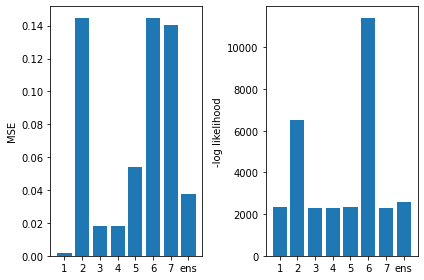

In [4]:
import matplotlib.pyplot as plt

def plot_evaluation(mse_run, ensemble_mse, model_probabilities, ensemble_prob):
    mse_min = np.min(mse_run+[ensemble_mse], axis=1)
    x_ticks = [str(x+1) for x in range(len(mse_run))]+["ens"]
    
    plt.subplot(1,2,1)
    plt.bar(x=x_ticks, height=mse_min)
    plt.ylabel("MSE")


    plt.subplot(1,2,2)
    plt.bar(x=x_ticks, height = np.divide(model_probabilities+[ensemble_prob],-1))
    plt.ylabel("-log likelihood")
    plt.tight_layout()
    return(plt)

plot = plot_evaluation(mse_run, ensemble_mse, model_probabilities, ensemble_prob)
plot.savefig("../../fig/runEval_1324.png", dpi=1000)

In [11]:
np.divide(model_probabilities+[ensemble_prob],-1)

array([ 2358.03      ,  6516.47      ,  2283.32      ,  2283.32      ,
        2349.63      , 11400.97      ,  2272.86      ,  2590.65821912])

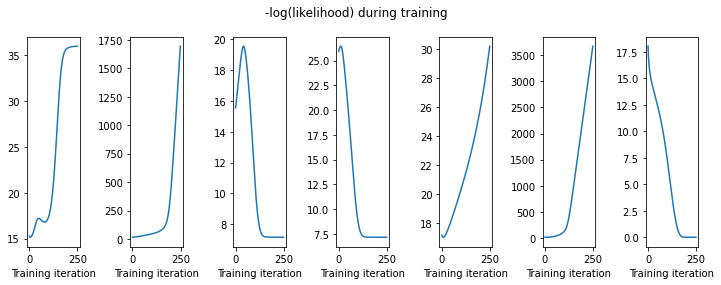

In [5]:
import matplotlib.pyplot as plt
x_ticks = list(range(training_iters))
plt.figure(figsize=(10,4))
plt.suptitle("-log(likelihood) during training")
for i in range(runs):
    #

    plt.subplot(1,runs, i+1)
    plt.plot(x_ticks, -train_logs[i])
    plt.tight_layout()
    plt.xlabel("Training iteration")

plot.savefig("../../fig/runEvalTraining_1324.png", dpi=1000)

In [13]:
est_em_list[0], est_trans_list[0], est_init_list[0]

(array([[0.158, 0.162, 0.162, 0.173, 0.157, 0.189],
        [0.152, 0.075, 0.088, 0.062, 0.096, 0.525]]),
 array([[0.939, 0.045],
        [0.141, 0.828]]),
 array([0.60032667, 0.39967333]))

In [14]:
est_em_list[6], est_trans_list[6], est_init_list[6]

(array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.156, 0.14 , 0.143, 0.145, 0.142, 0.274]]),
 array([[0.   , 0.516],
        [0.   , 0.98 ]]),
 array([1.97702238e-18, 1.00000000e+00]))

In [15]:
ensemble_emission, ensemble_transition , ensemble_init

(array([[0.52028571, 0.05285714, 0.08657143, 0.06957143, 0.05271429,
         0.21757143],
        [0.15471429, 0.14157143, 0.13357143, 0.13857143, 0.14642857,
         0.28514286]]),
 array([[0.62514286, 0.153     ],
        [0.41114286, 0.56871429]]),
 array([0.24619173, 0.75380827]))